In [9]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# from sklearn.metrics import classification_report


Preproccesing Functions

In [10]:
# Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new

Define the dataset

In [16]:
# Define the column names
import matplotlib.pyplot as plt
# folder_name = input("Please enter the subject name: ")

folder_name='f'
column_names = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ',
                'Battery', 'Sample', 'Unknown', 'Instruction', 'Female/Male', 'Outdoor/Indoor', 'Human Behavior']

selected_columns=['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
raw = []
event=[]
bandpass=[]
denoised=[]
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst=s_temp.iloc[:, 17]
            df_temp=s_temp.iloc[:, :8]
            raw.append(df_temp)
            event.append(inst)
            # print(df_temp.shape) # (10000, 8)
            
            #preprocess
            raw_eeg_bp = np.copy(df_temp)
            for column in range(df_temp.shape[1]):
                raw_eeg_bp[:, column] = butter_bandpass_filter(raw_eeg_bp[:, column], lowcut=.4, highcut=40, fs=250) 
            bandpass.append(raw_eeg_bp) 
            
            eeg_df_denoised = preprocess(pd.DataFrame(raw_eeg_bp, columns=selected_columns), col_names=selected_columns, n_clusters=[50]*len(selected_columns))    
            denoised.append(eeg_df_denoised)
            
            # for i in range(8):
            #     fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 2 subplots
            #     axs[0].plot(df_temp.iloc[:,i])
            #     axs[0].set_title(f'Original data of block {file_name.replace(".csv", "")} column {i}')
            #     axs[1].plot(raw_eeg_bp[:,i])
            #     axs[1].set_title(f'Filtered data of block {file_name.replace(".csv", "")} column {i}')
            #     axs[2].plot(eeg_df_denoised.iloc[:,i])
            #     axs[2].set_title(f'Denoised data of block {file_name.replace(".csv", "")} column {i}')
            #     plt.tight_layout()  # Adjusts subplot parameters for better fit
            #     plt.show()

In [17]:
event=np.array(event).reshape(40*10000, 1)
raw=np.array(raw).reshape(40*10000, 8)   
bandpass=np.array(bandpass).reshape(40*10000, 8)   
denoised=np.array(denoised).reshape(40*10000, 8)   
pp_sig_event=np.concatenate((denoised, event), axis=1)

labels=[] 
face = [] #lable=0
scene=[]#lable=1
for i in range(len(pp_sig_event)):
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    else:
        scene.append(pp_sig_event[i]) 
        labels.append(1)
        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels)     
             
print('event', event.shape, 'raw', raw.shape, 'bandpass', bandpass.shape, 'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)          

event (400000, 1) raw (400000, 8) bandpass (400000, 8) denoised (400000, 8) pp_sig_event (400000, 9) face (200000, 9) scene (200000, 9) labels (400000,)


In [ ]:
for i in range(8):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 2 subplots
    axs[0].plot(raw[:,i])
    axs[0].set_title(f'Original data of column {i}')
    axs[1].plot(bandpass[:,i])
    axs[1].set_title(f'Filtered data of column {i}')
    axs[2].plot(denoised[:,i])
    axs[2].set_title(f'Denoised data of column {i}')
    plt.tight_layout()  # Adjusts subplot parameters for better fit
    plt.show() 

In [18]:
face_eeg_dada=face.reshape(20,40,50,5,9)
face_eeg_dada=face_eeg_dada[:,:,:,:,:8]
face_eeg_dada=face_eeg_dada.mean(axis=3)
face_eeg_dada=face_eeg_dada.mean(axis=1)
print(face_eeg_dada.shape)
face_mean=face_eeg_dada.mean(axis=0)
print(face_mean.shape)

scene_eeg_dada=scene.reshape(20,40,50,5,9)
scene_eeg_dada=scene_eeg_dada[:,:,:,:,:8]
scene_eeg_dada=scene_eeg_dada.mean(axis=3)
scene_eeg_dada=scene_eeg_dada.mean(axis=1)
print(scene_eeg_dada.shape)
scene_mean=scene_eeg_dada.mean(axis=0)
print(scene_mean.shape, type(scene_mean))


(20, 50, 8)
(50, 8)
(20, 50, 8)
(50, 8) <class 'numpy.ndarray'>


In [6]:
fs=250
time_list=[]
for n in range(face_mean.shape[0]):
    time = (n*5)/(fs)*1000
    time_list.append(time)

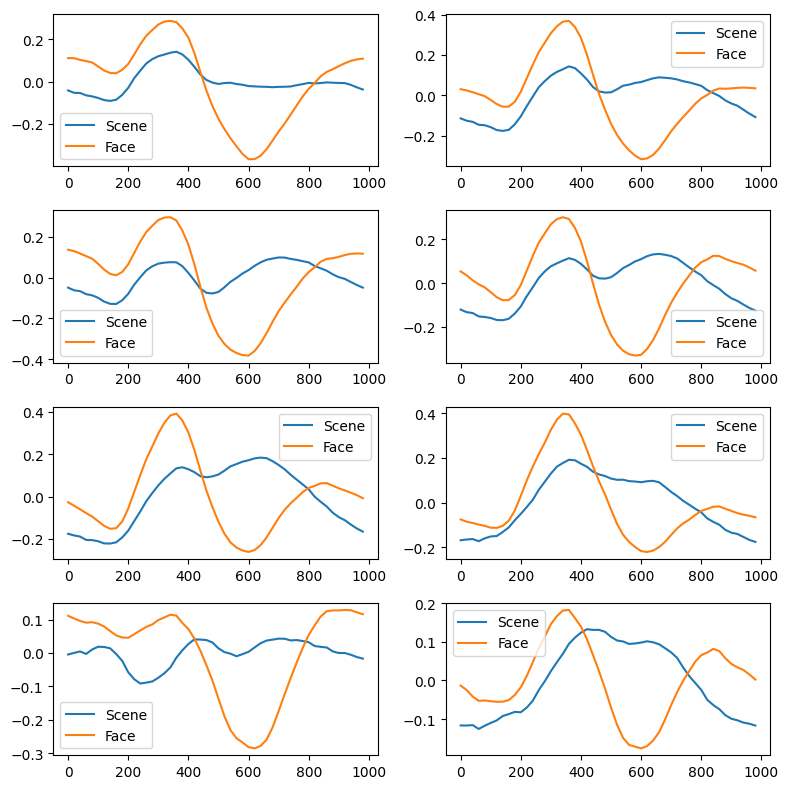

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for channel in range(8):
    plt.subplot(4, 2, channel + 1)  
    plt.plot(time_list, face_mean[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean[:, channel], label=f'Face')
    plt.legend()
plt.tight_layout()
plt.show()


ERP Feature Extraction

In [18]:
P300_window=(15,30) #DUE TO THE SAMPLING RATE
N600_window=(30,45)

def extract_features(epoch):
    P300_region=epoch[P300_window[0]:P300_window[1]]
    N600_region=epoch[N600_window[0]:N600_window[1]]
    
    # print(f"P300 region size: {P300_region.shape}")  
    # print(epoch.shape)
    # print(epoch[:10])
    
    P300_amplitude=np.max(P300_region)
    P300_mean_amplitude=np.mean(P300_region)
    P300_latency=np.argmax(P300_region)+P300_window[0]
    
    N600_amplitude=np.max(N600_region)
    N600_mean_amplitude=np.mean(N600_region)
    N600_latency=np.argmax(N600_region)+N600_window[0]
    
    return(P300_amplitude, P300_mean_amplitude, N600_amplitude, N600_mean_amplitude, P300_latency, N600_latency)

In [19]:
face_erp_features=np.array([extract_features(face_mean[:, channel])for channel in range(8)])
scene_erp_features=np.array([extract_features(scene_mean[:, channel])for channel in range(8)])

ERP_Features=np.concatenate([face_erp_features, scene_erp_features], axis=0)
normalized_erp_features=(ERP_Features-np.mean(ERP_Features, axis=0))/np.std(ERP_Features, axis=0)

In [20]:
normalized_erp_features.shape

(16, 6)

Adding white noise

In [30]:
import numpy as np

min_val_scene = np.min(scene_mean)
max_val_scene = np.max(scene_mean)

min_val_face = np.min(face_mean)
max_val_face = np.max(face_mean)

# Create white noise arrays
noise_before_scene = np.random.uniform(low=min_val_scene, high=max_val_scene, size=(50, 8))
noise_after_scene = np.random.uniform(low=min_val_scene, high=max_val_scene, size=(50, 8))

noise_before_face = np.random.uniform(low=min_val_face, high=max_val_face, size=(50, 8))
noise_after_face = np.random.uniform(low=min_val_face, high=max_val_face, size=(50, 8))

# Concatenate original array with noise
scene_mean_noise = np.concatenate((noise_before_scene,scene_mean, noise_after_scene), axis=0)
face_mean_noise = np.concatenate((noise_before_face,face_mean, noise_after_face), axis=0)

for column in range(scene_mean_noise.shape[1]):
    scene_mean_noise[:, column] = butter_bandpass_filter(scene_mean_noise[:, column], lowcut=.5, highcut=10, fs=250) 
    face_mean_noise[:, column] = butter_bandpass_filter(face_mean_noise[:, column], lowcut=.5, highcut=10, fs=250) 

scene_mean_noise = z_score(pd.DataFrame(scene_mean_noise, columns=selected_columns), col_names=selected_columns)  
scene_mean_noise =np.array(scene_mean_noise ) 
face_mean_noise = z_score(pd.DataFrame(face_mean_noise, columns=selected_columns), col_names=selected_columns)   
face_mean_noise =np.array(face_mean_noise ) 
                

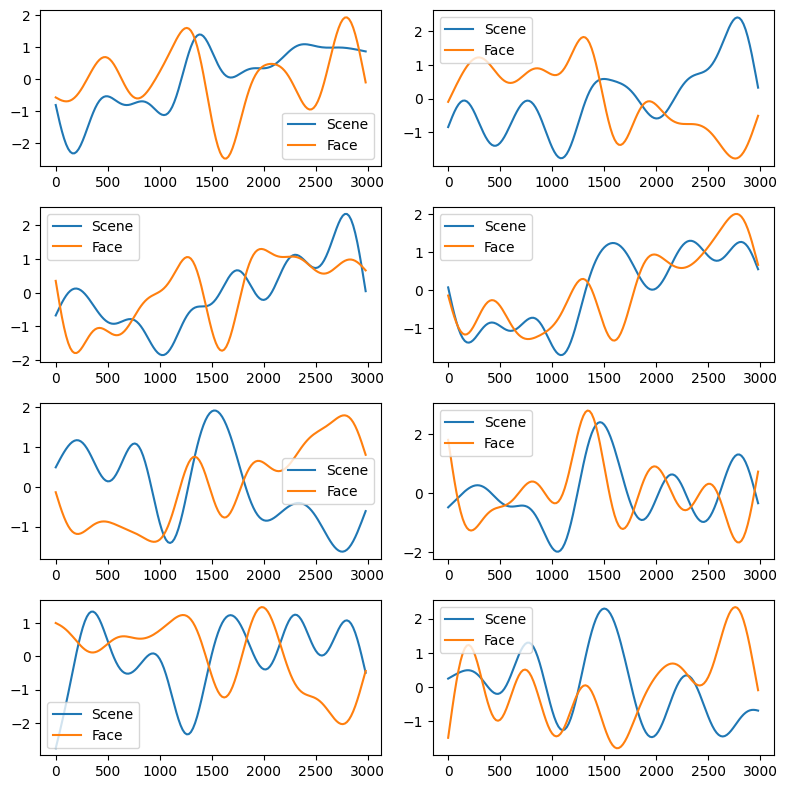

In [79]:
import matplotlib.pyplot as plt

fs=250
time_list=[]
for n in range(face_mean_noise.shape[0]):
    time = (n*5)/(fs)*1000
    time_list.append(time)

plt.figure(figsize=(8,8))
for channel in range(8):
    plt.subplot(4, 2, channel + 1)  
    plt.plot(time_list, face_mean_noise[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean_noise[:, channel], label=f'Face')
    plt.legend()
plt.tight_layout()
plt.show()


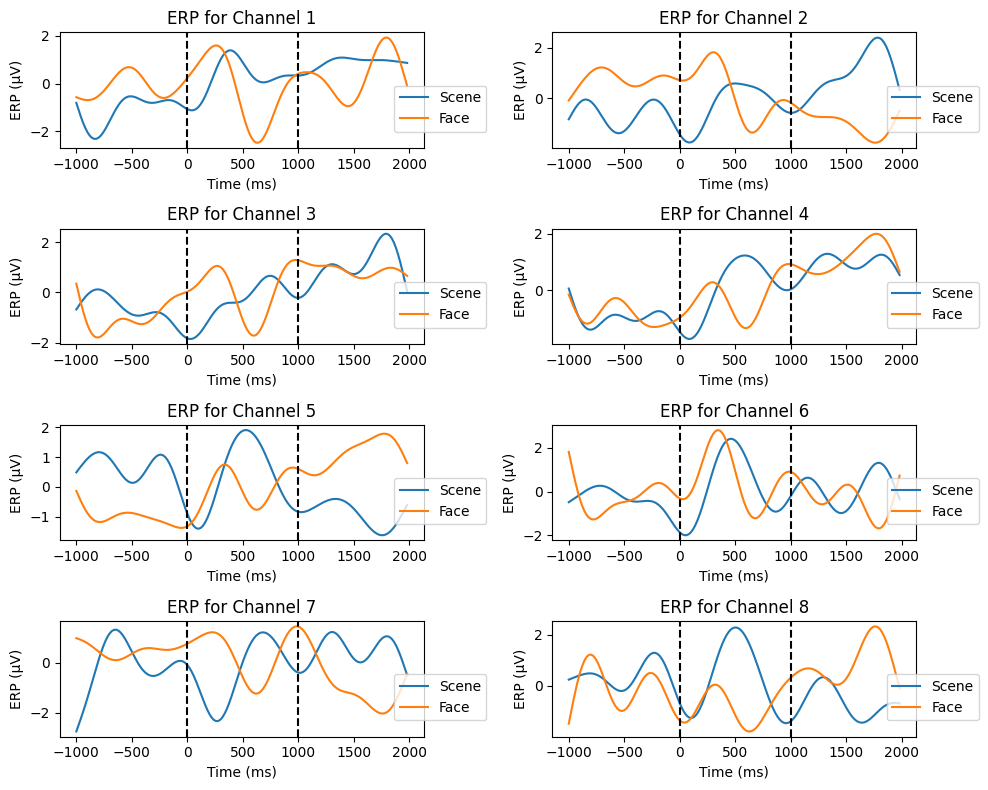

In [78]:
fs=250
shift = 1000  # shifting by 1000 ms (1 second)

time_list=[]
for n in range(face_mean_noise.shape[0]):
    time = ((n * 5) / fs) * 1000 - shift
    time_list.append(time)

plt.figure(figsize=(10,8))  # slightly increased figure size for better spacing
for channel in range(8):
    plt.subplot(4, 2, channel + 1)
    plt.plot(time_list, face_mean_noise[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean_noise[:, channel], label=f'Face')
    plt.axvline(x=0, color='k', linestyle='--')  # Adds a dashed vertical line at t=0
    plt.axvline(x=1000, color='k', linestyle='--')  # Adds a dashed vertical line at t=1000
    plt.title(f'ERP for Channel {channel + 1}')  # Adds a title for each subplot
    plt.xlabel('Time (ms)')  # Adds an x-axis label
    plt.ylabel('ERP (μV)')  # Adds a y-axis label with unit
    plt.legend(loc='upper left', bbox_to_anchor=(0.90, .6))  # Places the legend outside the plot
plt.tight_layout()
plt.show()



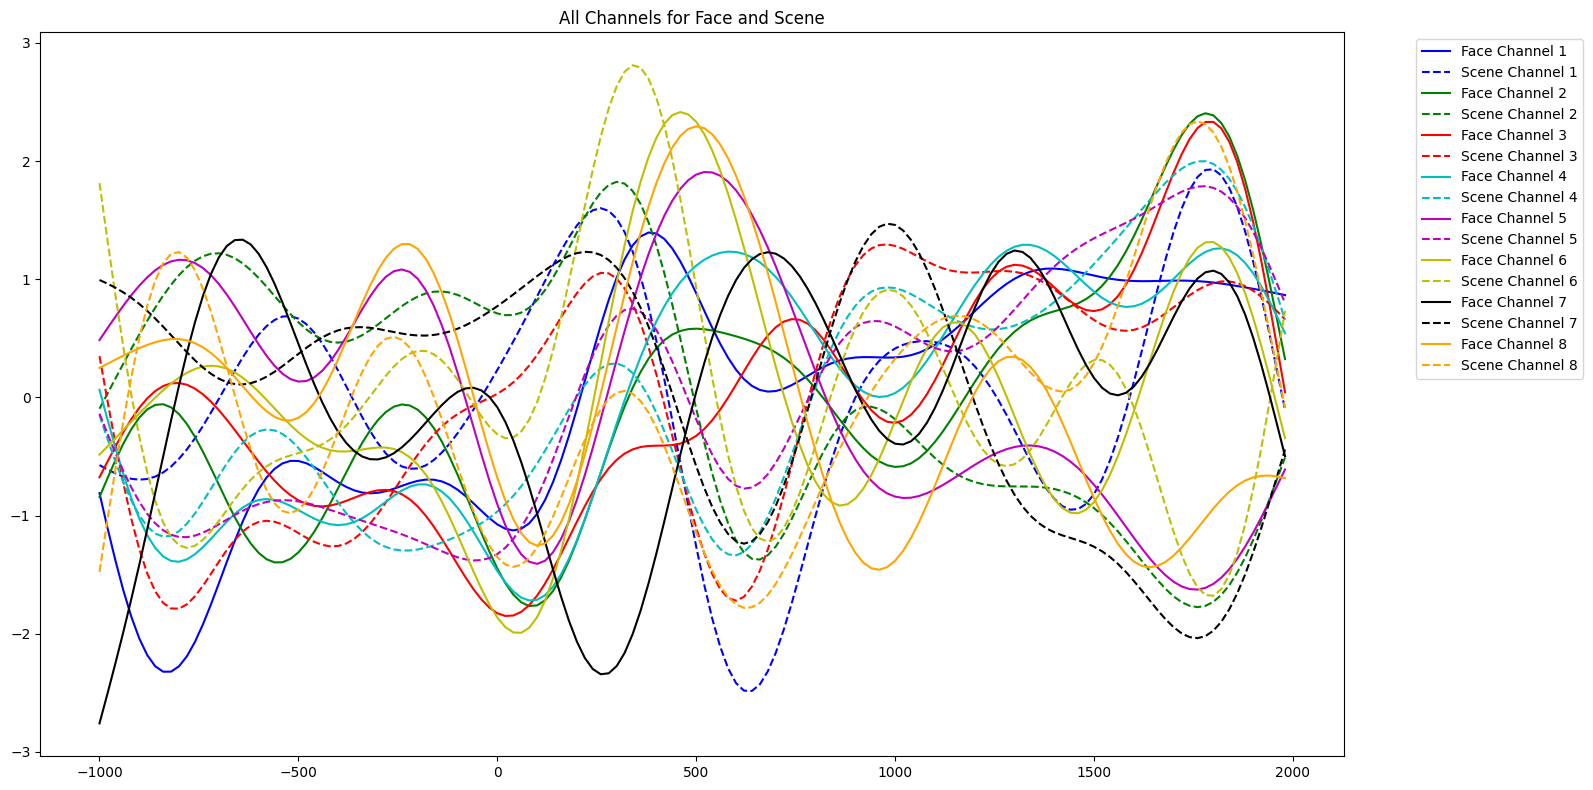

In [73]:
plt.figure(figsize=(16,8))

# Define the color palette for channels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']

for channel in range(8):
    # Use different colors for each channel
    plt.plot(time_list, face_mean_noise[:, channel], color=colors[channel], label=f'Face Channel {channel+1}')
    plt.plot(time_list, scene_mean_noise[:, channel], color=colors[channel], linestyle='dashed', label=f'Scene Channel {channel+1}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend box to outside of the plot
plt.title('All Channels for Face and Scene')
plt.tight_layout()
plt.show()


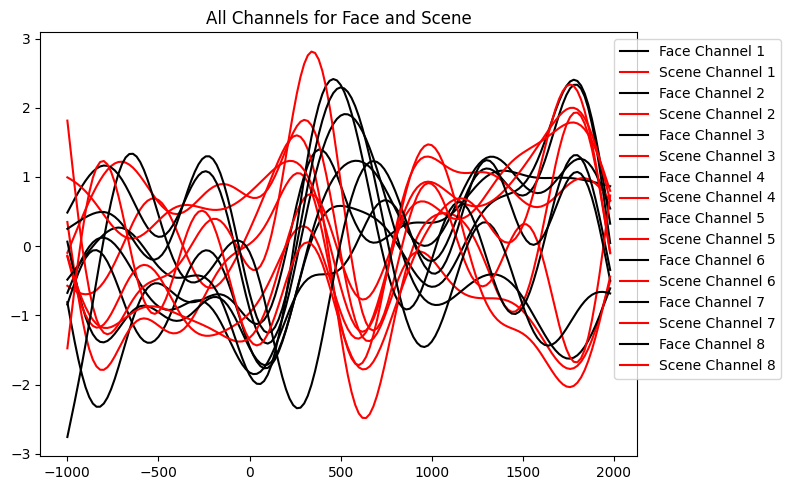

In [76]:
plt.figure(figsize=(8,5))

for channel in range(8):
    # Use 'k' for black for face data, and 'r' for red for scene data
    plt.plot(time_list, face_mean_noise[:, channel], color='k', label=f'Face Channel {channel+1}')
    plt.plot(time_list, scene_mean_noise[:, channel], color='r', label=f'Scene Channel {channel+1}')

plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left')  # Move the legend box to outside of the plot
plt.title('All Channels for Face and Scene')
plt.tight_layout()
plt.show()


Wavelet analysis

In [49]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

face_wavelet=face.reshape(800,250,9)
face_signal=face_wavelet[:,:,:8]

scene_wavelet=scene.reshape(800,250,9)
scene_signal=scene_wavelet[:,:,:8]


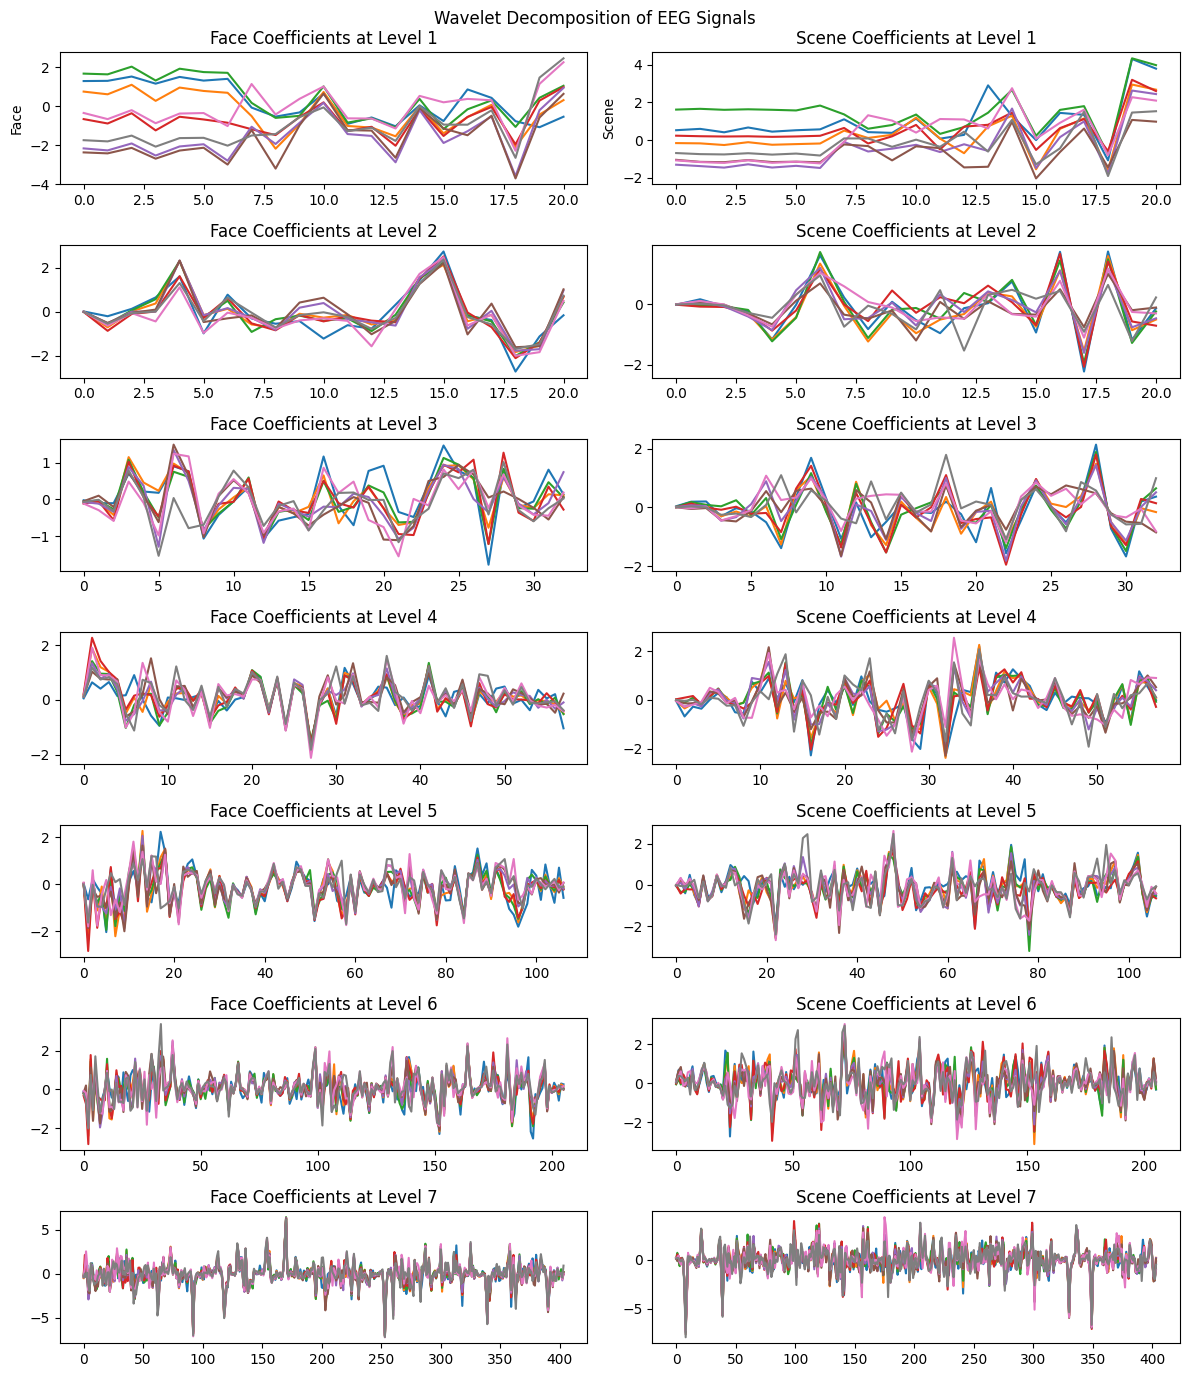

In [56]:
#Discrete
# choose the wavelet
wavelet = 'db5'
 
# perform the wavelet transform
face_coeffs = pywt.wavedec(face_signal, wavelet, axis=0)
scene_coeffs = pywt.wavedec(scene_signal, wavelet, axis=0)


# determine the number of decomposition levels
num_levels = len(face_coeffs)

# create subplots for each level
fig, axs = plt.subplots(num_levels, 2, figsize=(12, num_levels*2))

for level in range(num_levels):
    # plot the face coefficients
    axs[level, 0].plot(face_coeffs[level][:, 0])
    axs[level, 0].set_title(f'Face Coefficients at Level {level + 1}')

    # plot the scene coefficients
    axs[level, 1].plot(scene_coeffs[level][:, 0])
    axs[level, 1].set_title(f'Scene Coefficients at Level {level + 1}')

# add column labels
axs[0, 0].set_ylabel('Face')
axs[0, 1].set_ylabel('Scene')

# add a title to the figure
fig.suptitle('Wavelet Decomposition of EEG Signals')

# display the plot
plt.tight_layout()
plt.show()

In [92]:
# Specify the desired frequency range
min_frequency = 0.4
max_frequency = 40.0

# Convert the frequencies to scales
min_scale = pywt.frequency2scale(wavelet, max_frequency / 250)  # Divide by sampling rate to get normalized frequency
max_scale = pywt.frequency2scale(wavelet, min_frequency / 250)  # Divide by sampling rate to get normalized frequency

# Create a range of scales between the minimum and maximum scales
scales = np.arange(min_scale, max_scale + 1)  # Plus 1 to include the maximum scale


# Choose the wavelet 
wavelet = 'cmor1.5-1.0'


# Select a single image/segment from each condition
face_image_one = face_signal[200]  # first face image
scene_image_one = scene_signal[200]  # first scene image

# Compute the CWT for the selected images
face_cwt = np.abs(pywt.cwt(face_image_one, scales, wavelet)[0])
scene_cwt = np.abs(pywt.cwt(scene_image_one, scales, wavelet)[0])



# The scales in CWT correspond to pseudo-frequencies, we can compute these frequencies as follows:
frequencies = pywt.scale2frequency(wavelet, scales) * 250  # 250 is the sampling rate

In [66]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#continious

# Compute average amplitude over time for each condition
face_amp_avg = np.mean(face_signal, axis=0)
scene_amp_avg = np.mean(scene_signal, axis=0)

# Choose the wavelet 
wavelet = 'cmor1.5-1.0'


# Define scales
scales = np.arange(1, 51)

# Perform the CWT for each image and then average
face_cwt_avg = np.mean([np.abs(pywt.cwt(image, scales, wavelet)[0]) for image in face_signal], axis=0)
scene_cwt_avg = np.mean([np.abs(pywt.cwt(image, scales, wavelet)[0]) for image in scene_signal], axis=0)

# The scales in CWT correspond to pseudo-frequencies, we can compute these frequencies as follows:
frequencies = pywt.scale2frequency(wavelet, scales) * 250  # 250 is the sampling rate


In [ ]:
from matplotlib import gridspec

cmap_list = ['PRGn','seismic', 'viridis', 'jet',  'plasma', 'magma', 'inferno', 'cividis', 'terrain']


# Loop over each channel
for channel in range(8):
    # Create a figure
    fig = plt.figure(figsize=(8, 5))
    
    # Define the grid layout
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

    # Add subplot for face condition (CWT)
    ax1 = plt.subplot(gs[0])
    im1 = ax1.imshow(face_cwt_avg[:, :, channel], extent=[0, 1, min(frequencies), max(frequencies)], aspect='auto', cmap='jet', origin='lower')
    ax1.set_title(f'Average CWT - Face Condition, Channel {channel + 1}')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')
    fig.colorbar(im1, ax=ax1, orientation='vertical')  # Add colorbar

    # Add subplot for scene condition (CWT)
    ax2 = plt.subplot(gs[1])
    im2 = ax2.imshow(scene_cwt_avg[:, :, channel], extent=[0, 1, min(frequencies), max(frequencies)], aspect='auto', cmap='jet', origin='lower')
    ax2.set_title(f'Average CWT - Scene Condition, Channel {channel + 1}')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    fig.colorbar(im2, ax=ax2, orientation='vertical')  # Add colorbar

    # Add subplot for face and scene condition (average amplitude)
    ax3 = plt.subplot(gs[2:4])
    ax3.plot(face_amp_avg[:, channel], color='red', label='Face Condition')
    ax3.plot(scene_amp_avg[:, channel], color='blue', label='Scene Condition')
    ax3.set_title(f'Average Amplitude - Face and Scene Conditions, Channel {channel + 1}')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Amplitude (microV)')
    ax3.legend()
    
   
    # Show the plot
    plt.tight_layout()
    plt.show()


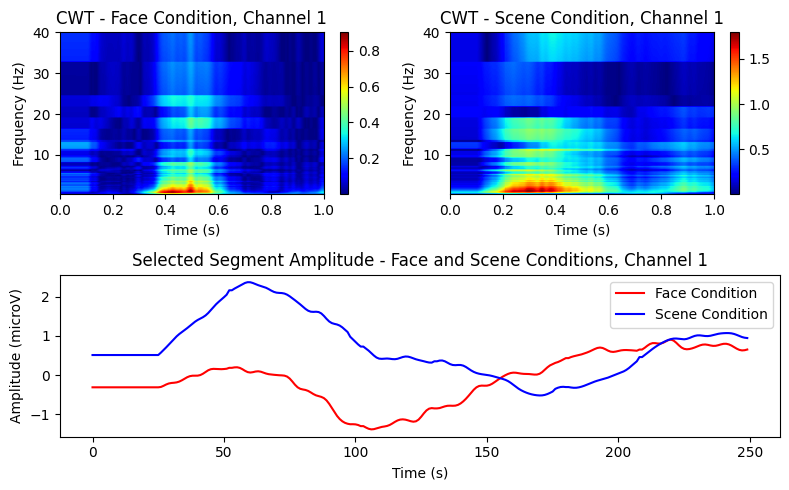

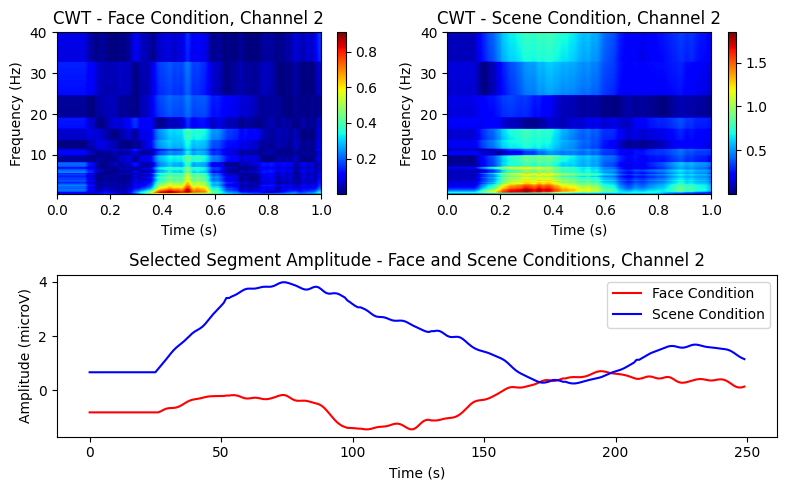

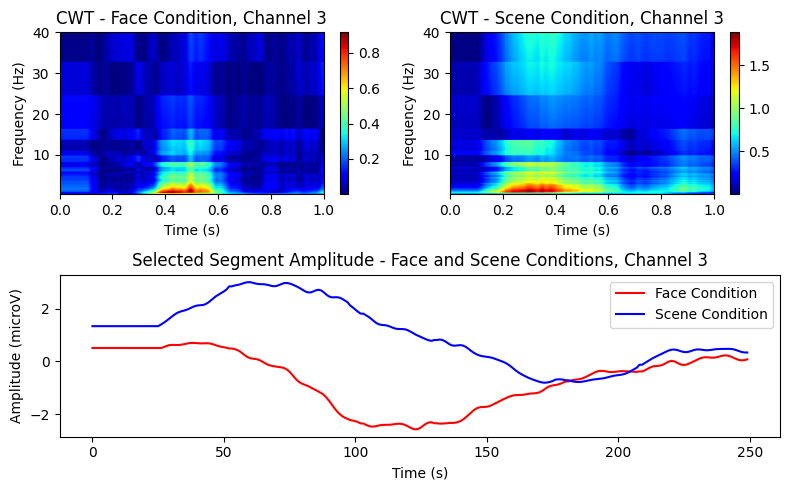

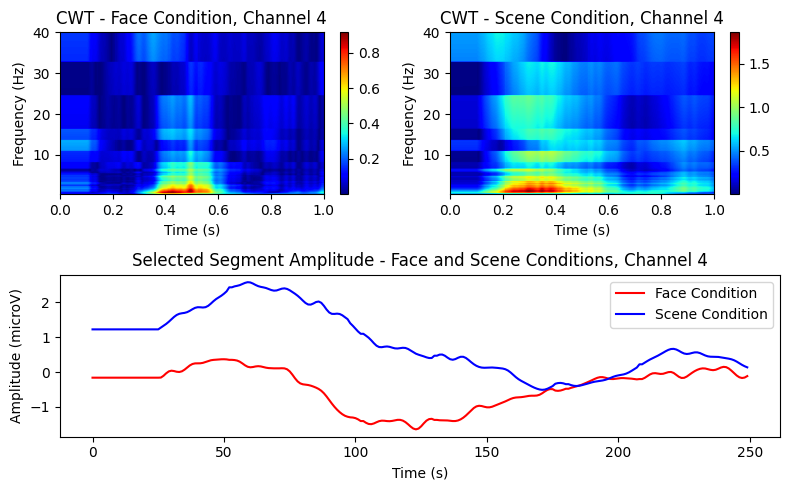

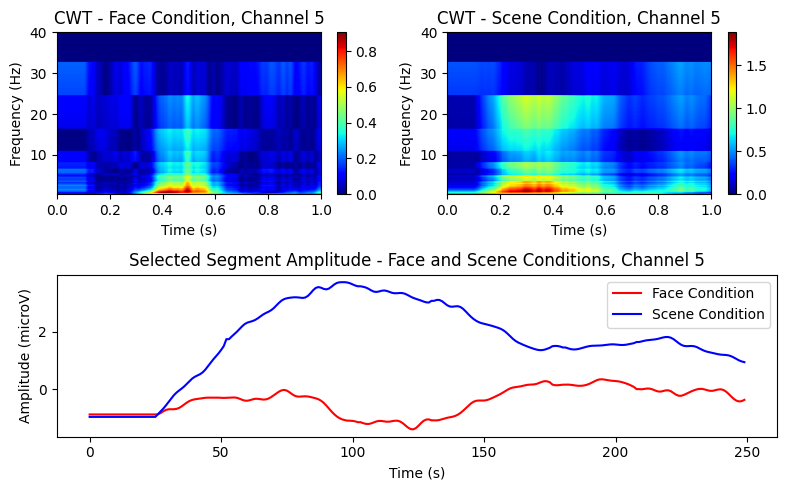

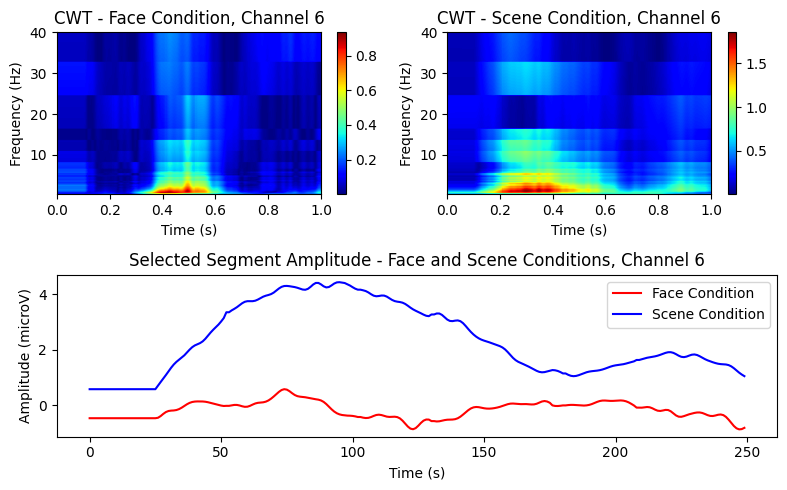

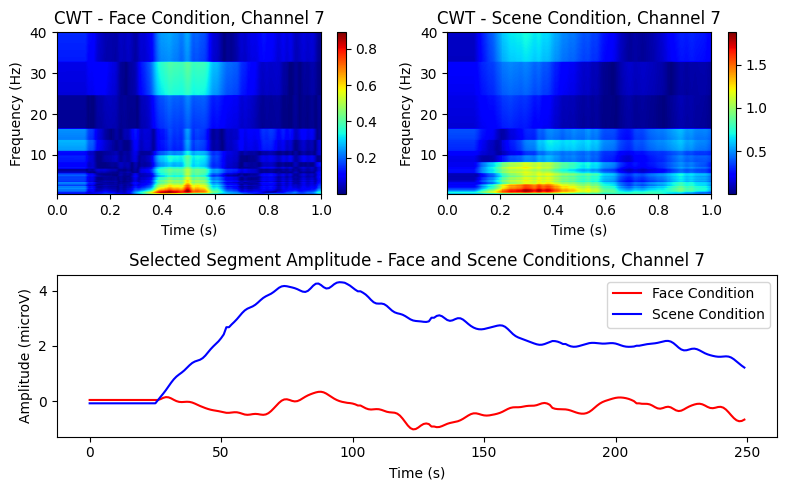

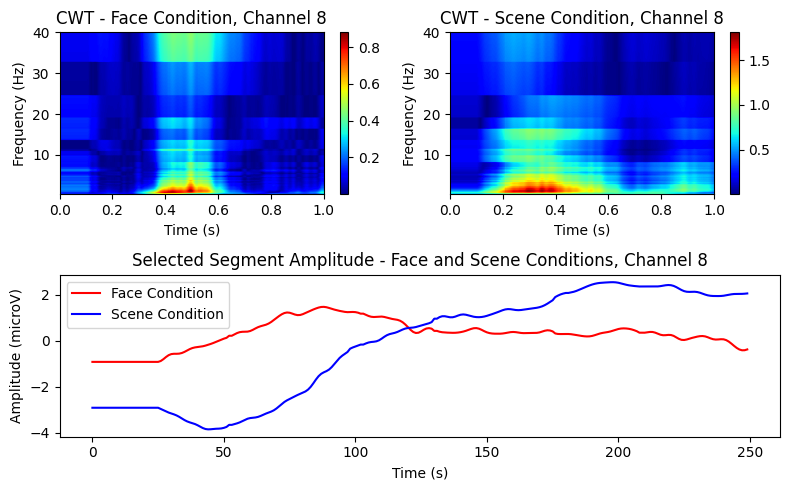

In [93]:
# Instead of calculating average amplitude, simply select the amplitude of your chosen segment
face_amp = face_image_one  # amplitude of first face image
scene_amp = scene_image_one  # amplitude of first scene image

# Continue with your code...

from matplotlib import gridspec

# Loop over each channel
for channel in range(8):
    # Create a figure
    fig = plt.figure(figsize=(8, 5))
    
    # Define the grid layout
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

    # Add subplot for face condition (CWT)
    ax1 = plt.subplot(gs[0])
    im1 = ax1.imshow(face_cwt[:, :, channel], extent=[0, 1, min(frequencies), max(frequencies)], aspect='auto', cmap='jet', origin='lower')
    ax1.set_title(f'CWT - Face Condition, Channel {channel + 1}')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')
    fig.colorbar(im1, ax=ax1)

    # Add subplot for scene condition (CWT)
    ax2 = plt.subplot(gs[1])
    im2 = ax2.imshow(scene_cwt[:, :, channel], extent=[0, 1, min(frequencies), max(frequencies)], aspect='auto', cmap='jet', origin='lower')
    ax2.set_title(f'CWT - Scene Condition, Channel {channel + 1}')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    fig.colorbar(im2, ax=ax2)

    # Add subplot for face and scene condition (selected amplitude)
    ax3 = plt.subplot(gs[2:4])
    ax3.plot(face_amp[:, channel], color='red', label='Face Condition')
    ax3.plot(scene_amp[:, channel], color='blue', label='Scene Condition')
    ax3.set_title(f'Selected Segment Amplitude - Face and Scene Conditions, Channel {channel + 1}')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Amplitude (microV)')
    ax3.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()



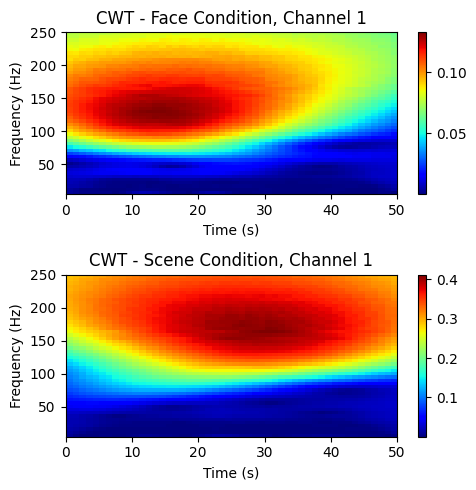

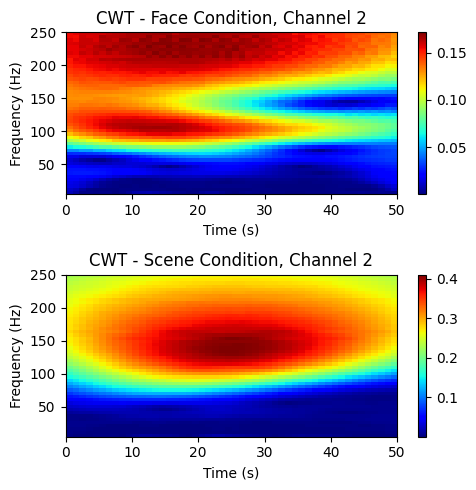

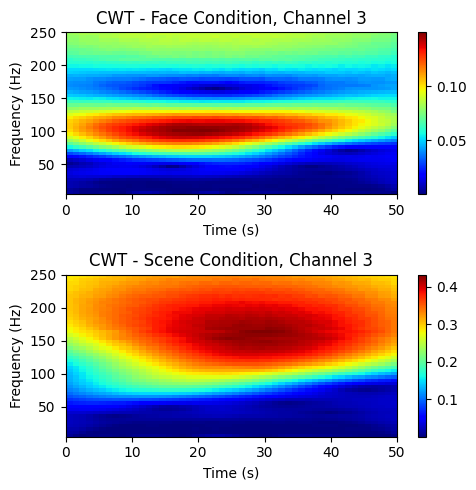

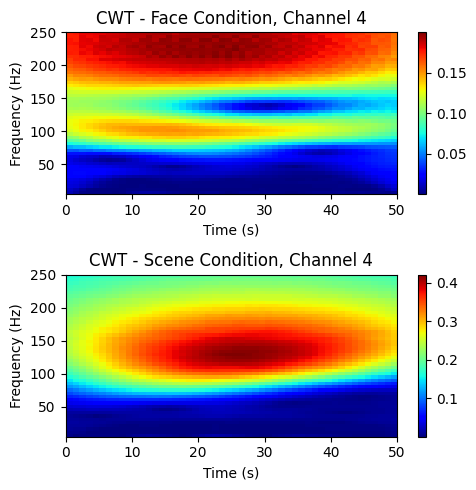

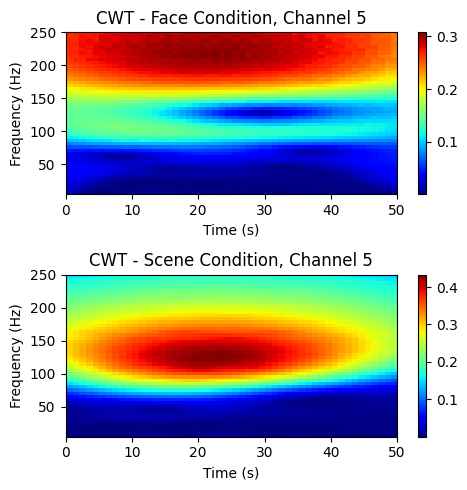

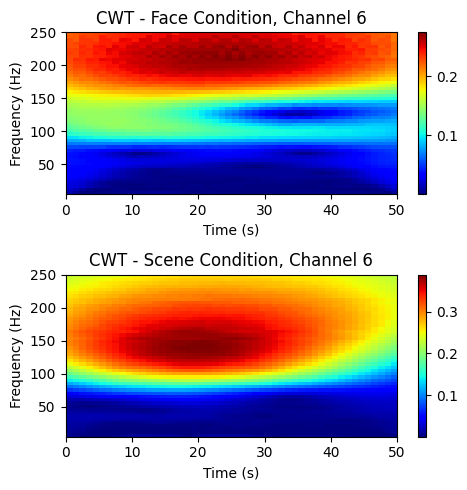

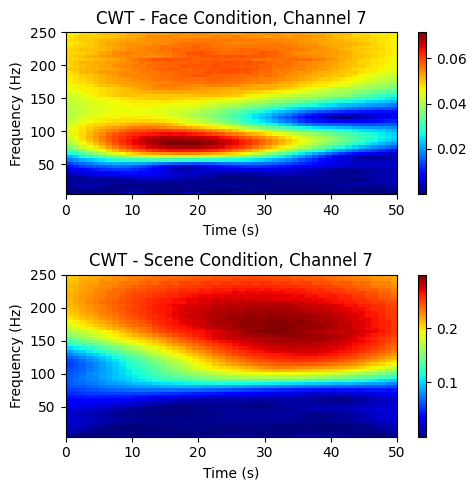

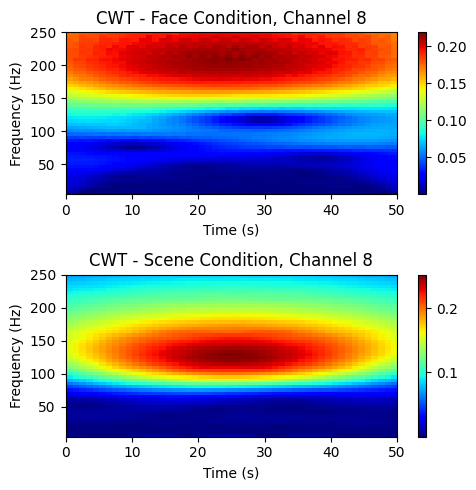

In [18]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Assuming face_signal and scene_signal are your EEG data with shape (50, 8)

# Choose the wavelet 
wavelet = 'cmor1.5-1.0'

# Define scales
scales = np.arange(1, 51)

# Perform the CWT
face_cwt, _ = pywt.cwt(face_mean, scales, wavelet, axis=0)
scene_cwt, _ = pywt.cwt(scene_mean, scales, wavelet, axis=0)

# The scales in CWT correspond to pseudo-frequencies, we can compute these frequencies as follows:
frequencies = pywt.scale2frequency(wavelet, scales) * 250  # 250 is the sampling rate

# Loop over each channel
for channel in range(8):
    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(5, 5))

    # Plot the CWT for the current channel for face condition
    cwt_face = face_cwt[:, :, channel]
    im1 = axs[0].imshow(np.abs(cwt_face), extent=[0, 50, min(frequencies), max(frequencies)], aspect='auto', cmap='jet', origin='lower')
    axs[0].set_title(f'CWT - Face Condition, Channel {channel + 1}')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Frequency (Hz)')
    fig.colorbar(im1, ax=axs[0], orientation='vertical')

    # Plot the CWT for the current channel for scene condition
    cwt_scene = scene_cwt[:, :, channel]
    im2 = axs[1].imshow(np.abs(cwt_scene), extent=[0, 50, min(frequencies), max(frequencies)], aspect='auto', cmap='jet', origin='lower')
    axs[1].set_title(f'CWT - Scene Condition, Channel {channel + 1}')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Frequency (Hz)')
    fig.colorbar(im2, ax=axs[1], orientation='vertical')

    # Show the plot
    plt.tight_layout()
    plt.show()



In [22]:
#event (400000, 1) raw (400000, 8) bandpass (400000, 8) denoised (400000, 8) pp_sig_event (400000, 9) face (200000, 9) scene (200000, 9) labels (400000,)

X=denoised.reshape(1600, 250*8)
labels=labels.reshape(1600, 250)
Y=np.squeeze(labels[:,0])
print(X.shape, Y.shape)

(1600, 2000) (1600,)


Feature Extraction

In [49]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert, welch
from scipy.stats import skew, kurtosis
from numpy import unwrap, diff, abs, angle

# Define bandpass filter
def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Define function to calculate hilbert features
def calculate_hilbert_features(signal, fs):
    analytic_signal = hilbert(signal)
    
    # Calculate amplitude envelope
    amplitude_envelope = abs(analytic_signal)
    
    # Calculate instantaneous phase
    instantaneous_phase = angle(analytic_signal)
    
    # Calculate instantaneous frequency
    unwrapped_phase = unwrap(instantaneous_phase)
    instantaneous_frequency = diff(unwrapped_phase) / (2.0*np.pi) * fs 
    
    return amplitude_envelope, #instantaneous_phase, instantaneous_frequency

# Define function to calculate statistical features
def calculate_statistical_features(signal):
    # Mean
    mean = np.mean(signal)
    
    # Standard deviation
    std = np.std(signal)
    
    # Skewness
    sk = skew(signal)
    
    # Kurtosis
    kurt = kurtosis(signal)
    
    return mean

# Define your sampling frequency
fs = 250

# Define your EEG signal here, assuming it's a 1D NumPy array
eeg_signal = X  # replace with your actual data

# Define frequency bands
frequency_bands = {'delta': (0.5, 4),
                   'theta': (4, 8),
                   'alpha': (8, 12),
                   'beta': (12, 30),
                   'gamma': (30, 100)}


In [50]:
import numpy as np
from scipy.signal import butter, filtfilt

fs = 250  # Sampling rate

# Defining the frequency bands
frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40)
}

def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


In [51]:
data = X

all_features = []

# Process each EEG signal corresponding to an image
for i in range(data.shape[0]):
    eeg_signal = data[i, :].reshape(8, 250)  # reshaped to (8, 250)
    features_for_sample = []
    for channel in range(8):
        channel_signal = eeg_signal[channel, :]
        
        features_for_channel = []  # List to hold features for this channel
        
        for band, (low, high) in frequency_bands.items():
            filtered_signal = apply_bandpass_filter(channel_signal, low, high, fs)
            
            # Extract mean amplitude as a feature for this band
            mean_amplitude = np.mean(np.abs(filtered_signal))
            features_for_channel.append(mean_amplitude)
        
        features_for_sample.append(features_for_channel)

    all_features.append(features_for_sample)

all_features = np.array(all_features)

print(all_features.shape)  # This should print (1600, 8, 5).


(1600, 8, 5)


In [68]:
all_features=all_features.reshape(1600, 8, 5)
x=X.reshape(1600, 8, 250)
all_feature = np.concatenate([all_features,x], axis=-1)
af=all_feature.reshape(1600, 8*255)

In [72]:
af, Y = shuffle(af, Y)
print(af.shape, Y.shape)


# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(af, Y)
X_resampled= X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.int32)

# Split X and y into training and testing sets
X_touched, X_untouch, y_touch, y_untouch = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_touched, y_touch, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_untouch=tf.keras.utils.to_categorical(y_untouch, num_classes=2)


# Convert the data to a numerical type (float)
X_train = X_train.astype(np.float64)
print(X_train.shape)



# Convert one-hot-encoded labels to integer-encoded labels
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)
y_untouch = np.argmax(y_untouch, axis=-1)
print(y_train.shape, y_test.shape)



print('X_train:', X_train.shape, 'y_train:', y_train.shape, 'X_test:', X_test.shape, 'y_test:',
      y_test.shape, 'X_untouch:', X_untouch.shape, 'y_untouch:', y_untouch.shape )

(1600, 2040) (1600,)
(1296, 2040)
(1296,) (144,)
X_train: (1296, 2040) y_train: (1296,) X_test: (144, 2040) y_test: (144,) X_untouch: (160, 2040) y_untouch: (160,)


In [73]:
from sklearn import svm
from joblib import dump
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
# Create a linear SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)
# Save the model to disk
filename = 'C:/Users/tnlab/OneDrive/Documents/GitHub/Neurofeedback-Based-BCI/SVM for Unicorn Data/my_svm_model.joblib'
dump(clf, filename)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print('Model accuracy: ', accuracy_score(y_test, y_pred))
report_svm_matrix = classification_report(y_test, y_pred)
print("Classification Report:")
print(report_svm_matrix)
report_svm = classification_report(y_test, y_pred, output_dict=True)

report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)

Model accuracy:  0.4166666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.49      0.44        68
           1       0.44      0.36      0.39        76

    accuracy                           0.42       144
   macro avg       0.42      0.42      0.42       144
weighted avg       0.42      0.42      0.41       144

